# BITCOIN BOT PROJECT - BACKTEST NOTEBOOK 3
The goal of this project is to develop a working trading bot with the binance api. The signaller is supertrend on the 1m timescale.

## Project Plan
#### PHASE 1 - DATA COLLECTION AND BACKTESTS
1. Data Collection
2. Data Clean
3. Build Supertrend Signal
4. Carry out back test
5. Tune back test hyperparameters
6. Investigate optimisation
7. Retune hyperparameters
8. Evaluate the strategy - Bot / no bot

#### PHASE 2 - BUILD AND TEST BOT IN LOCAL ENV
1. Review binance bot options and develop bot type / operation and functionality
2. Build bot
3. Test strategy offline
4. Debug and optimise
5. Add new data to initial phase 1 backtest to see if results are comparable and hyperparameters similar or unchanged
6. Debug / optimise / retest in local env


#### PHASE 3 - LIVE TESTS
1. Commence live tests with small initial capital and low risk
2. Add new data to initial phase 1 backtest to see if results are comparable and hyperparameters similar or unchanged
3. Debug / optimise / retest in live environment

#### PHASE 4 - RUN BOT
1. RUN BOT WITH FULLY OPTIMISED STRATEGY / HYPERPARAMETERS / RISK 
2. COLLECT GAINS

## Notebook Aim
Simplify backtest from notebook's 1 and 2.

Our trade return calculation had become complex beyond the capability for it to make sense. We'll try to make a simplified model here.

In [1]:
#!pip install mplfinance

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import time
import warnings
import math

from tqdm import tqdm
from collections import Counter

import mplfinance as mpf

pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

In [4]:
# Read in the supertrend dataframe
df = pd.read_csv("supertrend.csv", infer_datetime_format=['time'], parse_dates=['time'])

In [5]:
print(df.shape)
df

(74097, 14)


,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct
0,2022-03-14 00:00:00,37793.40,37797.17,37763.47,37780.14,NaN,0.0,no_signal,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-14 00:01:00,37780.13,37806.22,37757.05,37806.22,NaN,NaN,no_signal,nosig,NaN,NaN,NaN,NaN,NaN
2,2022-03-14 00:02:00,37811.02,37819.97,37794.89,37816.18,NaN,NaN,no_signal,nosig,NaN,NaN,NaN,NaN,NaN
3,2022-03-14 00:03:00,37816.18,37818.51,37756.99,37797.80,NaN,NaN,no_signal,nosig,NaN,NaN,NaN,NaN,NaN
4,2022-03-14 00:04:00,37798.49,37822.67,37786.75,37809.06,NaN,NaN,no_signal,nosig,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74092,2022-05-04 10:52:00,38984.31,38996.00,38972.90,38972.90,38937.958676,NaN,buy,nosig,23.70,46.80,0.120,23.70,0.061
74093,2022-05-04 10:53:00,38972.90,38975.48,38952.30,38954.80,38937.958676,NaN,buy,nosig,5.60,26.28,0.067,3.10,0.008
74094,2022-05-04 10:54:00,38954.89,38959.55,38942.29,38959.55,38937.958676,NaN,buy,nosig,10.35,10.35,0.027,-6.91,-0.018
74095,2022-05-04 10:55:00,38963.11,38986.54,38950.19,38960.11,38937.958676,NaN,buy,nosig,10.91,37.34,0.096,0.99,0.003


In [6]:
# Get the trigger data points
trigs = df[(df.trigger=="sellsig") | (df.trigger=="buysig")]
# We need to reset the index for future joins
trigs.reset_index(inplace=True)
trigs.rename(columns={'index':'trade_idx'}, inplace=True)

In [7]:
print(trigs.shape)
trigs.tail()

(2046, 15)


,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct
2041,73738,2022-05-04 04:58:00,37981.83,37992.17,37981.21,37992.17,37941.527545,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0
2042,73991,2022-05-04 09:11:00,38870.50,38884.80,38844.64,38851.75,NaN,38972.800555,sell,sellsig,0.0,0.0,0.0,0.0,0.0
2043,74016,2022-05-04 09:36:00,38961.24,38998.38,38961.23,38983.28,38888.346164,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0
2044,74026,2022-05-04 09:46:00,38954.56,38954.56,38888.00,38904.83,NaN,39037.197336,sell,sellsig,0.0,0.0,0.0,0.0,0.0
2045,74066,2022-05-04 10:26:00,38929.30,38954.46,38923.82,38949.20,38858.287474,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0


#### NARRATIVE / PLAN

1. For each trade we'll return the max trade pct on the trigger point. 
2. For each trade we'll return the max drawdown pctr on the trigger point.
3. For each trade we'll return whether the trade closes in profit from the entry or not
4. For each trade we'll return the pct diff from entry to close
5. For each trade we'll return the trade close price for future calcs


#### Next Step
1. Based on tp parameters we can return the pct change from best tp to close. 

#### 1. Max pct per trade

In [8]:
# Create a list to store our max gain per trade
trade_gain = []

# Get the required trade indexes
trade_idx = trigs.trade_idx



# We can't measure the last trade signal as we don't have the data yet, loop through the rest.
for i, j in enumerate(trade_idx[:-1]): 
    max_gain = 0
    
    # Get an individual trade data
    trade = df.loc[j:trade_idx[i+1]]
    
    # Loop through the trade datapoints
    for index, row in trade.iterrows():
        
        # Store the best todate max gain for the trade
        if row["max_pct"]>max_gain:
            max_gain=row["max_pct"]
    
    # Store the best result in the trade gain list. If we cannot beat a max gain of 0 then our max gain is 0!!
    trade_gain.append(max_gain)

In [9]:
print(len(trade_gain))
trade_gain[:5]

2045


[0.402, 1.3430000000000002, 0.408, 0.08199999999999999, 0.003]

In [10]:
# Ok let's convert to dataframe and join with the trigger set
cols = ["trade_gain"]
gain = pd.DataFrame(trade_gain, columns=cols)
trigs1=trigs.join(gain)

In [11]:
trigs1.trade_gain.sum()

737.416

In [12]:
trigs1.head()

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792000,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.402
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343
2,84,2022-03-14 01:24:00,38080.27,38094.26,38037.45,38059.44,NaN,38218.679324,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.408
3,116,2022-03-14 01:56:00,38075.68,38087.78,38069.85,38087.78,37974.284582,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.082
4,122,2022-03-14 02:02:00,38047.23,38066.65,37990.01,37990.01,NaN,38152.364011,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.003


#### 2. Trade Drawdown

In [13]:
# Create a list to store our max gain per trade
trade_drawdown= []

# Get the required trade indexes
trade_idx = trigs.trade_idx



# We can't measure the last trade signal as we don't have the data yet, loop through the rest.
for i, j in enumerate(trade_idx[:-1]): 
    max_drawdown = 0
    
    # Get an individual trade data
    trade = df.loc[j:trade_idx[i+1]]
    
    # Loop through the trade datapoints
    for index, row in trade.iterrows():
        
        # Store the best todate max gain for the trade
        if row["max_dd_pct"]<max_drawdown:
            max_drawdown=row["max_dd_pct"]
    
    # Store the best result in the trade gain list. If we cannot beat a max gain of 0 then our max gain is 0!!
    trade_drawdown.append(max_drawdown)

In [14]:
cols = ["drawdown"]
dd = pd.DataFrame(trade_drawdown, columns=cols)
trigs2=trigs1.join(dd)

In [15]:
trigs2.tail()

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown
2041,73738,2022-05-04 04:58:00,37981.83,37992.17,37981.21,37992.17,37941.527545,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,2.721,-0.111
2042,73991,2022-05-04 09:11:00,38870.50,38884.80,38844.64,38851.75,NaN,38972.800555,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.000,-0.336
2043,74016,2022-05-04 09:36:00,38961.24,38998.38,38961.23,38983.28,38888.346164,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.235,-0.072
2044,74026,2022-05-04 09:46:00,38954.56,38954.56,38888.00,38904.83,NaN,39037.197336,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.278,-0.150
2045,74066,2022-05-04 10:26:00,38929.30,38954.46,38923.82,38949.20,38858.287474,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,NaN,NaN


#### 3. Trade Closes in Profit 1/0

In [16]:
# Create a list to store our max gain per trade
close_profit = []
close_change = []

# Get the required trade indexes
trade_idx = trigs.trade_idx



# We can't measure the last trade signal as we don't have the data yet, loop through the rest.
for i, j in enumerate(trade_idx[:-1]): 

    # Get an individual trade data
    trade = df.loc[j:trade_idx[i+1]]
    
    # Get the trade entry and close price
    trade_entry = trade.iloc[0].close
    trade_close = trade.loc[trade_idx[i+1]].close
   
        
    # If buys then we want to know if the last trade candle closes up from the entry price?
    if trade.iloc[0].signal=="buy":
        # Get the close price of the last candle - the reversal data point
        
        if trade_close>trade_entry:
            close_profit.append(1)
            price_increase = trade_close-trade_entry
            close_change.append(price_increase)
        else:
            close_profit.append(0)
            price_decrease = trade_close-trade_entry
            close_change.append(price_decrease)
    
    elif trade.iloc[0].signal=="sell":
        # Get the close price of the last candle - the reversal data point
        
        if trade_close<trade_entry:
            close_profit.append(1)
            price_increase = trade_entry-trade_close
            close_change.append(price_increase)
        else:
            close_profit.append(0)
            price_decrease = trade_entry-trade_close
            close_change.append(price_decrease)

# Add 0 to the end of each list to complete all rows
close_profit.append(0)
close_change.append(0)

In [17]:
df_close = pd.DataFrame({"close_prof": close_profit, "close_change": close_change})


In [18]:
# Join this data to the running trigs dataset
trigs3 = trigs2.join(df_close)

In [19]:
# Let's make soem queries to see how the data fits together
# trigs2[(trigs2.trade_gain<0.35) & (trigs2.close_prof==0)]
trigs3

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792000,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.402,-0.115,0,-127.84
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60
2,84,2022-03-14 01:24:00,38080.27,38094.26,38037.45,38059.44,NaN,38218.679324,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.408,-0.206,0,-28.34
3,116,2022-03-14 01:56:00,38075.68,38087.78,38069.85,38087.78,37974.284582,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.082,-0.175,0,-97.77
4,122,2022-03-14 02:02:00,38047.23,38066.65,37990.01,37990.01,NaN,38152.364011,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.003,-0.473,0,-181.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,73738,2022-05-04 04:58:00,37981.83,37992.17,37981.21,37992.17,37941.527545,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,2.721,-0.111,1,859.58
2042,73991,2022-05-04 09:11:00,38870.50,38884.80,38844.64,38851.75,NaN,38972.800555,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.000,-0.336,0,-131.53
2043,74016,2022-05-04 09:36:00,38961.24,38998.38,38961.23,38983.28,38888.346164,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.235,-0.072,0,-78.45
2044,74026,2022-05-04 09:46:00,38954.56,38954.56,38888.00,38904.83,NaN,39037.197336,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.278,-0.150,0,-44.37


#### 5. Trade close price
Get the trade close price???

#### NARRATIVE
OK we have constructed some data that may help us create a simple backtester.

#### PLAN
1. Set the parameters for tp1,2,3 and P1,2,3
2. Set a capital which shouldn't matter to start with so we'll set at £100
3. Set each tp take profit value and new position
4. If tp3 hit add up all the profit takes and store in a new list of trade profits
5. If only tp1 or tp2 hit calculate the tp profit takes and then the stop profit take. Add up and add to trade list.

In [97]:
# Set the trade parameters
tp1 = 0.35
tp2 = 0.54
tp3 = 0.7
p1 = 0.25
p2 = 0.25
p3 = 0.75

capital = 100

In [ ]:
# Set the trade progression values and metrics

tp1_position = capital*(1+(tp1/10))
tp1_secure = tp1_position*p1
tp1_new_pos = tp1_position*(1-p1)

tp2_position = tp1_new_pos*(1+((tp2-tp1)/10))
tp2_secure = tp2_position*p2
tp2_new_pos = tp2_position*(1-p2)

tp3_position = tp2_new_pos*(1+((tp3-tp2)/10))

In [ ]:
tp1_position, tp1_new_pos, tp1_secure

In [ ]:
tp2_position, tp2_secure, tp2_new_pos

In [ ]:
tp3_position

#### TP3 HIT

In [ ]:
# Get the return for a tp3 hit
tp3_return = tp1_secure+tp2_secure+tp3_position
tp3_return

In [ ]:
# Get the percent return for a tp3 hit
pct_return = ((tp3_return/capital)-1)*100
round(pct_return,2)

#### TP1 HIT and STOP
The trade hits tp1 but then retraces to a stopout

In [ ]:
tp1_position, tp1_secure, tp1_new_pos

In [ ]:
##### SELLSSS - close in loss

In [ ]:
# First get the tp1 BTCUSD price which is entry price+tp1%
entry=37712
tp1_price=entry*(1-(tp1/100))
close_price=37839

In [ ]:
tp1_price

In [ ]:
# Get the %agechange from tp1 price tp close price
pct_change = close_price/tp1_price
pct_change = pct_change-1
pct_change

In [ ]:
pos_change = tp1_new_pos*(pct_change*10)
pos_change

In [ ]:
final_pos = tp1_new_pos-pos_change
final_pos

In [ ]:
tp1_return = tp1_secure+final_pos
tp1_return

In [ ]:
###### BUYSSSS close in loss
buy_entry = 38826
buy_tp1_price = buy_entry*(1+(tp1/100))
buy_close_price = 38783

In [ ]:
buy_tp1_price

In [ ]:
# Get the %agechange from tp1 price tp close price
buy_pct_change = buy_close_price/buy_tp1_price
buy_pct_change = 1-buy_pct_change
buy_pct_change

In [ ]:
buy_pos_change = tp1_new_pos*(buy_pct_change*10)
buy_pos_change

In [ ]:
buy_final_pos = tp1_new_pos-buy_pos_change
buy_final_pos

In [ ]:
buy_tp1_return = tp1_secure+buy_final_pos
buy_tp1_return

In [ ]:
##### SELLLS close in profit (trigs2 idx 16)
sell_prof_entry = 39137
sell_prof_tp1 = sell_prof_entry*(1-(tp1/100))
sell_prof_close = 39083

In [ ]:
sell_prof_tp1

In [ ]:
sell_prof_pct = sell_prof_close/sell_prof_tp1
sell_prof_pct = sell_prof_pct-1
sell_prof_pct

In [ ]:
sell_prof_pos_change = tp1_new_pos*(sell_prof_pct*10)
sell_prof_pos_change

In [ ]:
sell_prof_final = tp1_new_pos-sell_prof_pos_change
sell_prof_final

In [ ]:
sell_prof_tp1_return = tp1_secure+sell_prof_final
sell_prof_tp1_return

In [ ]:
##### BUUUYSSSS CLOSE IN PROFIT
buy_prof_entry = 38922
buy_prof_tp1 = buy_prof_entry*(1+(tp1/100))
buy_prof_close = 38947

In [ ]:
buy_prof_tp1

In [ ]:
buy_prof_pct = buy_prof_close/buy_prof_tp1
buy_prof_pct = 1-buy_prof_pct
buy_prof_pct

In [ ]:
buy_prof_pos_change = tp1_new_pos*(buy_prof_pct*10)
buy_prof_pos_change

In [ ]:
buy_prof_final = tp1_new_pos-buy_prof_pos_change
buy_prof_final

In [ ]:
buy_prof_tp1_return = tp1_secure+buy_prof_final
buy_prof_tp1_return

In [19]:
trigs3.loc[40:43]

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change
40,1424,2022-03-14 23:44:00,39661.05,39664.71,39557.29,39560.65,NaN,39774.747183,sell,sellsig,0.0,0.0,0.0,0.0,0.0,2.026,-0.605,1,638.19
41,1567,2022-03-15 02:07:00,38915.29,38927.33,38909.82,38922.46,38803.901844,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.523,-0.136,1,25.29
42,1628,2022-03-15 03:08:00,38964.96,38968.48,38934.67,38947.75,NaN,39041.560201,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.764,-0.090,1,123.20
43,1698,2022-03-15 04:18:00,38806.53,38837.90,38798.93,38824.55,38721.710100,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.120,-0.112,0,-65.40


In [21]:
# trigs2[(trigs2.trade_gain>0.54) & (trigs2.trade_gain<0.7) & (trigs2.close_change<0)]
trigs3[trigs3.trade_gain<0.35]

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change
3,116,2022-03-14 01:56:00,38075.68,38087.78,38069.85,38087.78,37974.284582,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.082,-0.175,0,-97.77
4,122,2022-03-14 02:02:00,38047.23,38066.65,37990.01,37990.01,NaN,38152.364011,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.003,-0.473,0,-181.47
5,155,2022-03-14 02:35:00,38148.45,38178.07,38147.44,38171.48,38069.154029,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.053,-0.206,0,-102.47
6,167,2022-03-14 02:47:00,38099.36,38103.05,38061.10,38069.01,NaN,38178.386474,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.247,-0.091,0,-10.19
8,271,2022-03-14 04:31:00,38586.09,38586.14,38415.84,38415.84,NaN,38758.790939,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.000,-0.476,0,-180.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,69979,2022-05-01 14:19:00,37973.85,38005.00,37973.40,38002.62,37936.792583,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.018,-0.191,0,-70.77
1934,69988,2022-05-01 14:28:00,37942.49,37942.99,37929.92,37931.85,NaN,37997.487723,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.080,-0.098,0,-46.26
1936,70138,2022-05-01 16:58:00,38510.86,38522.12,38485.19,38487.41,NaN,38593.494914,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.006,-0.225,0,-105.29
1937,70148,2022-05-01 17:08:00,38567.43,38600.00,38544.24,38592.70,38482.825378,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.000,-0.193,0,-96.93


In [98]:
trigs3.to_csv("trigs3.csv", index=False)

#### NARRATIVE
Ok good! We have a clear method of calculating the following:
1. tp3 hits and close. 
2. tp1 hits to stop outs in profit and loss
3. tp2 hits to stop outs in profit
4. Straight stop outs



#### PLAN
Lets build a code block that runs the backtest

In [20]:
results_list = []

# Set the trade parameters
tp1 = 0.33
tp2 = 0.52
tp3 = 0.58
p1 = 0.01
p2 = 0.1
p3 = 0.89

# Set the capital
capital = 100

# Set the trade progression values and metrics
tp1_position = capital*(1+(tp1/10))
tp1_secure = tp1_position*p1
tp1_new_pos = tp1_position*(1-p1)

tp2_position = tp1_new_pos*(1+((tp2-tp1)/10))
tp2_secure = tp2_position*p2
tp2_new_pos = tp2_position*(1-p2)

tp3_position = tp2_new_pos*(1+((tp3-tp2)/10))

# Get the return for a tp3 hit
tp3_return = tp1_secure+tp2_secure+tp3_position

# Get the percent return for a tp3 hit
tp3_pct_return = round(((tp3_return/capital)-1)*100,2)


for index, row in trigs3.iterrows():
    
    # Return tp3 profit
    if row["trade_gain"]>=tp3:
        results_list.append(tp3_pct_return)
        
        
    # RETURN TP1 AND STOP OUTS    
    elif row["trade_gain"]>=tp1 and row["trade_gain"]<tp2:
        
        if row["signal"]=="sell" and row["close_prof"]==0:
            ###code
            # First get the tp1 BTCUSD price which is entry price+tp1%
            entry=row["close"]
            tp1_price=entry*(1-(tp1/100))
            close_price=trigs3.loc[index+1].close

            # Get the %agechange from tp1 price tp close price
            pct_change = close_price/tp1_price
            pct_change = pct_change-1

            # Get the real change to our position
            pos_change = tp1_new_pos*(pct_change*10)

            # Calculate the final position
            final_pos = tp1_new_pos-pos_change

            tp1_return = tp1_secure+final_pos
            pct_change = ((tp1_return/capital)-1)*100
            results_list.append(pct_change)

        elif row["signal"]=="sell" and row["close_prof"]==1:
            ###code
            ##### SELLLS close in profit (trigs3 idx 16)
            sell_prof_entry = row["close"]
            sell_prof_tp1 = sell_prof_entry*(1-(tp1/100))
            sell_prof_close = trigs3.loc[index+1].close


            sell_prof_pct = sell_prof_close/sell_prof_tp1
            sell_prof_pct = sell_prof_pct-1

            sell_prof_pos_change = tp1_new_pos*(sell_prof_pct*10)

            sell_prof_final = tp1_new_pos-sell_prof_pos_change

            sell_prof_tp1_return = tp1_secure+sell_prof_final
            pct_change = ((sell_prof_tp1_return/capital)-1)*100
            results_list.append(pct_change)
                  
                
        elif row["signal"]=="buy" and row["close_prof"]==0:
            
            ###### BUYSSSS close in loss
            buy_entry = row["close"]
            buy_tp1_price = buy_entry*(1+(tp1/100))
            buy_close_price = trigs3.loc[index+1].close


            # Get the %agechange from tp1 price tp close price
            buy_pct_change = buy_close_price/buy_tp1_price
            buy_pct_change = 1-buy_pct_change

            buy_pos_change = tp1_new_pos*(buy_pct_change*10)

            buy_final_pos = tp1_new_pos-buy_pos_change

            buy_tp1_return = tp1_secure+buy_final_pos
            pct_change = ((buy_tp1_return/capital)-1)*100
            results_list.append(pct_change)
            
            
        elif row["signal"]=="buy" and row["close_prof"]==1:
            
            ##### BUUUYSSSS CLOSE IN PROFIT
            buy_prof_entry = row["close"]
            buy_prof_tp1 = buy_prof_entry*(1+(tp1/100))
            buy_prof_close = trigs3.loc[index+1].close

            buy_prof_pct = buy_prof_close/buy_prof_tp1
            buy_prof_pct = 1-buy_prof_pct

            buy_prof_pos_change = tp1_new_pos*(buy_prof_pct*10)

            buy_prof_final = tp1_new_pos-buy_prof_pos_change

            buy_prof_tp1_return = tp1_secure+buy_prof_final
            
            pct_change = ((buy_prof_tp1_return/capital)-1)*100
            results_list.append(pct_change)
            
    
    
    
    # RETURN TP2 and STOP OUTS
    elif row["trade_gain"]>=tp2 and row["trade_gain"]<tp3:
        
        if row["signal"]=="sell" and row["close_prof"]==0:
            ###code
            # First get the tp2 BTCUSD price which is entry price+tp2%
            entry=row["close"]
            tp2_price=entry*(1-(tp2/100))
            close_price=trigs3.loc[index+1].close

            # Get the %agechange from tp2 price tp close price
            pct_change = close_price/tp2_price
            pct_change = pct_change-1

            # Get the real change to our position
            pos_change = tp2_new_pos*(pct_change*10)

            # Calculate the final position
            final_pos = tp2_new_pos-pos_change

            tp2_return = tp2_secure+tp1_secure+final_pos
            pct_change = ((tp2_return/capital)-1)*100
            results_list.append(pct_change)

        elif row["signal"]=="sell" and row["close_prof"]==1:
            ###code
            ##### SELLLS close in profit (trigs3 idx 16)
            sell_prof_entry = row["close"]
            sell_prof_tp2 = sell_prof_entry*(1-(tp2/100))
            sell_prof_close = trigs3.loc[index+1].close


            sell_prof_pct = sell_prof_close/sell_prof_tp2
            sell_prof_pct = sell_prof_pct-1

            sell_prof_pos_change = tp2_new_pos*(sell_prof_pct*10)

            sell_prof_final = tp2_new_pos-sell_prof_pos_change

            sell_prof_tp2_return = tp2_secure+tp1_secure+sell_prof_final
            pct_change = ((sell_prof_tp2_return/capital)-1)*100
            results_list.append(pct_change)
                
        elif row["signal"]=="buy" and row["close_prof"]==0:
            
            ###### BUYSSSS close in loss
            buy_entry = row["close"]
            buy_tp2_price = buy_entry*(1+(tp2/100))
            buy_close_price = trigs3.loc[index+1].close


            # Get the %agechange from tp2 price tp close price
            buy_pct_change = buy_close_price/buy_tp2_price
            buy_pct_change = 1-buy_pct_change

            buy_pos_change = tp2_new_pos*(buy_pct_change*10)

            buy_final_pos = tp2_new_pos-buy_pos_change

            buy_tp2_return = tp2_secure+tp1_secure+buy_final_pos
            pct_change = ((buy_tp2_return/capital)-1)*100
            results_list.append(pct_change)
            
            
        elif row["signal"]=="buy" and row["close_prof"]==1:
            
            ##### BUUUYSSSS CLOSE IN PROFIT
            buy_prof_entry = row["close"]
            buy_prof_tp2 = buy_prof_entry*(1+(tp2/100))
            buy_prof_close = trigs3.loc[index+1].close

            buy_prof_pct = buy_prof_close/buy_prof_tp2
            buy_prof_pct = 1-buy_prof_pct

            buy_prof_pos_change = tp2_new_pos*(buy_prof_pct*10)

            buy_prof_final = tp2_new_pos-buy_prof_pos_change

            buy_prof_tp2_return = tp2_secure+tp1_secure+buy_prof_final
            
            pct_change = ((buy_prof_tp2_return/capital)-1)*100
            results_list.append(pct_change)
            
            
    # RETURN CLEAN STOPS
    elif row["trade_gain"]<tp1:
        
        if row["signal"]=="sell":
            entry=row["close"]
            close_price = trigs3.loc[index+1].close
            pct_change = close_price/entry
            pct_change = pct_change-1
            
            # Get the real change to our position
            pos_change = capital*(pct_change*10)

            # Calculate the final position
            final_pos = capital-pos_change

            stop_return = final_pos
            pct_change = ((final_pos/capital)-1)*100
            results_list.append(pct_change)
        
        elif row["signal"]=="buy":
            ###### BUYSSSS close in loss
            entry = row["close"]
            close_price = trigs3.loc[index+1].close
            pct_change = close_price/entry

            pct_change = 1-pct_change
            pos_change = capital*(pct_change*10)
            
            final_pos = capital-pos_change

            stop_return = final_pos
            pct_change = ((final_pos/capital)-1)*100
            results_list.append(pct_change)
            
            
            
    

In [21]:
len(results_list)

2045

In [22]:
res = pd.DataFrame(results_list, columns=["results"])
res

,results
0,-3.564214
1,5.810000
2,-0.850011
3,-2.566965
4,-4.776782
...,...
2040,-0.112931
2041,5.810000
2042,-3.385433
2043,-2.012401


In [23]:
# trigs_res.drop("results", axis=1, inplace=True)

In [24]:
trigs_res = trigs3.join(res)

In [25]:
trigs_res

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792000,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.402,-0.115,0,-127.84,-3.564214
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60,5.810000
2,84,2022-03-14 01:24:00,38080.27,38094.26,38037.45,38059.44,NaN,38218.679324,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.408,-0.206,0,-28.34,-0.850011
3,116,2022-03-14 01:56:00,38075.68,38087.78,38069.85,38087.78,37974.284582,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.082,-0.175,0,-97.77,-2.566965
4,122,2022-03-14 02:02:00,38047.23,38066.65,37990.01,37990.01,NaN,38152.364011,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.003,-0.473,0,-181.47,-4.776782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,73738,2022-05-04 04:58:00,37981.83,37992.17,37981.21,37992.17,37941.527545,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,2.721,-0.111,1,859.58,5.810000
2042,73991,2022-05-04 09:11:00,38870.50,38884.80,38844.64,38851.75,NaN,38972.800555,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.000,-0.336,0,-131.53,-3.385433
2043,74016,2022-05-04 09:36:00,38961.24,38998.38,38961.23,38983.28,38888.346164,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.235,-0.072,0,-78.45,-2.012401
2044,74026,2022-05-04 09:46:00,38954.56,38954.56,38888.00,38904.83,NaN,39037.197336,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.278,-0.150,0,-44.37,-1.140475


In [26]:
wins = trigs_res[trigs_res.results>0]
wins.shape, wins.results.sum(), wins.results.mean()

((723, 20), 2533.721671549435, 3.5044559772467982)

In [27]:
losses = trigs_res[trigs_res.results<0]
losses.shape, losses.results.sum(), losses.results.mean()

((1322, 20), -2660.1950896101634, -2.012250445998611)

In [28]:
big_losses = trigs_res[trigs_res.results<-2.71]
big_losses

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792000,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.402,-0.115,0,-127.84,-3.564214
4,122,2022-03-14 02:02:00,38047.23,38066.65,37990.01,37990.01,NaN,38152.364011,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.003,-0.473,0,-181.47,-4.776782
8,271,2022-03-14 04:31:00,38586.09,38586.14,38415.84,38415.84,NaN,38758.790939,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.000,-0.476,0,-180.20,-4.690773
9,311,2022-03-14 05:11:00,38563.83,38596.04,38540.67,38596.04,38449.576314,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.061,-0.298,0,-110.33,-2.858583
13,526,2022-03-14 08:46:00,39069.08,39095.09,39068.53,39077.07,38954.896721,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.174,-0.180,0,-113.10,-2.894280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,72840,2022-05-03 14:00:00,38354.86,38409.78,38354.86,38408.53,38208.266012,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.172,-0.289,0,-219.07,-5.703681
2016,72852,2022-05-03 14:12:00,38310.84,38311.53,38173.73,38189.46,NaN,38422.461025,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.083,-0.485,0,-150.35,-3.936950
2019,72961,2022-05-03 16:01:00,38325.98,38386.55,38323.25,38361.07,38257.927214,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.071,-0.255,0,-146.35,-3.815066
2023,73115,2022-05-03 18:35:00,37751.27,37827.73,37734.83,37809.00,37601.223013,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.077,-0.407,0,-191.06,-5.053294


In [29]:
# How many of our big losses hit tp1 first. ..... 
big_losses[big_losses.trade_gain>tp1] # 3

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792000,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.402,-0.115,0,-127.84,-3.564214
789,28086,2022-04-02 12:06:00,46548.01,46697.05,46548.01,46645.20,46493.506648,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.385,-0.005,0,-190.92,-4.235758
790,28089,2022-04-02 12:09:00,46698.24,46701.69,46400.00,46454.28,NaN,46802.946204,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.456,-0.516,0,-253.28,-5.680291
961,33991,2022-04-06 14:31:00,44172.01,44288.58,44164.22,44277.46,44021.498150,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.398,-0.224,0,-137.86,-3.237370
963,34060,2022-04-06 15:40:00,44031.59,44112.90,44026.11,44106.44,43765.707831,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.361,-0.272,0,-122.30,-2.890082
1054,37220,2022-04-08 20:20:00,42717.82,42731.47,42672.52,42694.04,NaN,42844.266543,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.367,-0.086,0,-117.99,-2.921611
1218,42746,2022-04-12 16:26:00,40172.93,40172.93,40059.53,40069.55,NaN,40292.219751,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.348,-0.229,0,-107.26,-2.832578
1258,44069,2022-04-13 14:29:00,40733.03,40737.19,40585.18,40599.77,NaN,40918.318902,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.513,-0.381,0,-180.68,-4.652212
1666,59899,2022-04-24 14:19:00,39571.04,39575.46,39550.65,39553.02,NaN,39642.114443,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.447,-0.026,0,-117.25,-3.127600
1742,62911,2022-04-26 16:31:00,38712.73,38715.72,38556.73,38561.77,NaN,38889.983984,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.472,-0.268,0,-139.00,-3.784513


In [30]:
big_losses.shape

(303, 20)

#### NARRATIVE
We have losses totalling 1198 and winners totalling 1163. 

#### TOTAL RETURN
1163-1193 = -35 \
Our strategy has returned -35% over 22 days thats approx -1.6% per day


### HARD STOP REVIEW
Can setting a hard stop size improve our performance?

#### NARRATIVE
1. We have 137 trades where we lose greater than 2.71% on the trade. 
2. If we set our stop at 2.71% drawdown... 
3. ...how much do we save on these losses and ...
4. ...how much do we lose on our wins. 

In [31]:
# What we need to make up / the overall percentage profit of our initial backtest
backtest = wins.results.sum()+losses.results.sum()
backtest

-126.47341806072836

#### 3. How much do we save on losses

In [32]:
stop = -2.71
big_loss_sum = big_losses.results.sum()
new_stop_sum = big_losses.shape[0]*stop
big_loss_sum, new_stop_sum

(-1241.269097094016, -821.13)

In [33]:
loss_savings = new_stop_sum-big_loss_sum
loss_savings # 179%

420.13909709401594

#### 4. How much do we lose on wins

In [34]:
# Base wins
wins_sum = wins.results.sum()
num_wins = wins.shape[0]
wins_sum, num_wins

(2533.721671549435, 723)

In [35]:
new_wins = wins[wins.drawdown>(stop/10)].results.sum()
num_new_wins = wins[wins.drawdown>(stop/10)].shape
new_wins, num_new_wins

(2295.6755022519533, (670, 20))

In [36]:
win_red = wins_sum-new_wins
win_red

238.0461692974818

In [37]:
# Don't forget the lost wins also now become losses :(((
wins_to_losses = (num_wins-num_new_wins[0])*stop
wins_to_losses

-143.63

In [38]:
# Change to base profit backtest
bt_change = loss_savings-win_red+wins_to_losses
bt_change

38.46292779653413

In [39]:
##### New backtest profit 
backtest+bt_change

-88.01049026419423

In [40]:
f"approx {round(1017/40)} trading days"

'approx 25 trading days'

#### HARD STOP NARRATIVE
1. Setting a hard stop of -2.71% has returned an extra -15% (over this trade period ~22days) to the portfolio. Our strategy now returns -50%. So the hard stop has actually made the strategy worse!!

In [41]:
lost_winners = wins[wins.drawdown<(stop/10)]
print(lost_winners.shape)
lost_winners.head()

(53, 20)


,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60,5.810000
40,1424,2022-03-14 23:44:00,39661.05,39664.71,39557.29,39560.65,NaN,39774.747183,sell,sellsig,0.0,0.0,0.0,0.0,0.0,2.026,-0.605,1,638.19,5.810000
69,2717,2022-03-15 21:17:00,39482.75,39535.58,39482.28,39527.11,39361.586574,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.943,-0.336,1,92.90,5.810000
80,3036,2022-03-16 02:36:00,41007.15,41022.03,40787.65,40902.13,NaN,41374.398531,sell,sellsig,0.0,0.0,0.0,0.0,0.0,5.017,-0.326,1,1744.96,5.810000
93,3556,2022-03-16 11:16:00,40379.10,40490.74,40372.01,40490.74,40283.581484,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.514,-0.328,1,26.09,0.593074


#### REVIEW OF LOST WINNERS
Let's take a look at the winners that have been missed by tightening the stop loss

In [42]:
lost_winners.drawdown.mean(), lost_winners.results.sum()

(-0.405056603773585, 238.04616929748198)

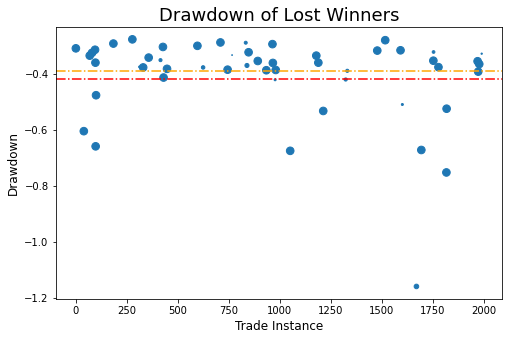

In [43]:
plt.figure(figsize=(8,5))
plt.scatter(x=lost_winners.index, y=lost_winners.drawdown, s=lost_winners.results*10)
plt.title("Drawdown of Lost Winners", fontsize=18)
plt.xlabel("Trade Instance", fontsize=12)
plt.ylabel("Drawdown", fontsize=12);
plt.axhline(y=-0.42, linestyle='-.', color='r')
plt.axhline(y=-0.39, linestyle='-.', color='orange')



In [44]:
# Let's look at the mean win results and the mean results of the lost wins
win_mean = wins.results.mean()
lost_win_mean = lost_winners.results.mean()
win_mean, lost_win_mean

(3.5044559772467982, 4.491437156556263)

#### NARRATIVE - THE BELOW FIGURES VARY
1. 24 of 27 (88%) of lost winners have a drawdown better than -4.2%. 
2. 23 of 27 (85%) of lost winners have a drawdown better than -3.9%.
3. Our average lost winner result is 4.5%win which is better that the average winner in the whole set. 

In short we have an incentive to try and recover some of this ost value.

#### PLAN

So what we are thinking is to look at partial stops. E.G let's say we take 50% of the trade of the table at the optimium stop of -2.71% but then set a second stop at -4% which stops out the rest. This gives the trade the air to collect the 85% of previous winners that would otherwise have been lost. 

1. We're looking at 50% of the initial returns for all the winners that we know have bounced. Calculate this gain in value.
2. Of the losers that had a larger stop than -2.71%, we need to get those that had a stop between -2.71% and -4%. Of these we need calculate the new stop stratgey returns. 
3. We should also look at the potential to add to positions that bounce hard back into winning territory as these seem to be decent wins?!?!

#### 1. Calculate winners retained percentages

In [45]:
# Get 50% of the results of lost winners that have a drawdown higher than -4%
partial_results = lost_winners[lost_winners.drawdown>-0.4].results.sum()/2
partial_results
# So with the above strategy we gain an extra 49%

90.9270445995907

In [46]:
temp = trigs_res[trigs_res.results<-4]
temp1 = trigs_res[(trigs_res.results>-4) & (trigs_res.results<-2.71)]

In [47]:
temp.shape

(116, 20)

In [48]:
temp1.shape

(187, 20)

In [49]:
temp1.results.mean()

-3.250760492042381

#### NARRATIVE
1. 44 losers go from -2.71% to -3.34% which is ~0.63% worse
2. 93 losers go from -2.71% to -3.27% which is ~0.56% worse
3. This is an extra drop of 79% which completely negates our lost winner gain of 49%!! A net drop of 30% taking us back into the red!!

#### Summary
The partial stop loss does not improve the strategy.

#### Next Steps
We have seen that a partial stop does not really help us due to the nuber of losers in the optimul partial stop window. However what if we retain the hard stop of 2.71% but allow to reopen the stopped trasde should price reverse in our favoured direction? We will undertake a review to see if this improves our overall gain.



## TRADE PROGRESSION
Let's see how our hard stop strategy progresses through the available period of time.

In [50]:
trigs_res.head()

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792000,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.402,-0.115,0,-127.84,-3.564214
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60,5.810000
2,84,2022-03-14 01:24:00,38080.27,38094.26,38037.45,38059.44,NaN,38218.679324,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.408,-0.206,0,-28.34,-0.850011
3,116,2022-03-14 01:56:00,38075.68,38087.78,38069.85,38087.78,37974.284582,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.082,-0.175,0,-97.77,-2.566965
4,122,2022-03-14 02:02:00,38047.23,38066.65,37990.01,37990.01,NaN,38152.364011,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.003,-0.473,0,-181.47,-4.776782


In [51]:
# Build the hard stop feature
hard_stop = []
stop=-2.71

for index, row in trigs_res.iterrows():
    
    """
    Build the hard stop results
    """
    
    if row["results"]<stop:
        hard_stop.append(stop)
    elif row["results"]>stop and row["drawdown"]<stop/10:
        hard_stop.append(stop)
    elif row["results"]>stop:
        hard_stop.append(row["results"])
    else:
        hard_stop.append(0)
        


In [52]:
sum(hard_stop)
### OK we've now realised our hard stop slightly worsens the original strategy

-104.75324250505874

In [53]:
# Convert to dataframe and add to 
hard_stop_df = pd.DataFrame(hard_stop, columns=["hard_stop"])

trigs_res1 = trigs_res.join(hard_stop_df)

In [55]:
trigs_res1.head(2)

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results,hard_stop
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.402,-0.115,0,-127.84,-3.564214,-2.71
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60,5.810000,-2.71


In [134]:
trigs_res.results.sum(), trigs_res1.hard_stop.sum()
# HArd stop has made things worse as we already predicted.\

(-126.47341806072878, -104.7532425050602)

#### NARRATIVE
As per our previous narrative comments our lost winners have surpringly large returns. In fact as we can see below if we could get back into these trades we could potential set a higher tp3 as the mean gain is more than double the mean returns with the initial parameters.

In [135]:
trigs_res1.trade_gain.mean(), lost_winners.results.mean(), lost_winners.trade_gain.mean()*10

(0.3605946210268949, 4.491437156556263, 10.572264150943397)

In [136]:
lost_winners.head()

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60,5.810000
40,1424,2022-03-14 23:44:00,39661.05,39664.71,39557.29,39560.65,NaN,39774.747183,sell,sellsig,0.0,0.0,0.0,0.0,0.0,2.026,-0.605,1,638.19,5.810000
69,2717,2022-03-15 21:17:00,39482.75,39535.58,39482.28,39527.11,39361.586574,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.943,-0.336,1,92.90,5.810000
80,3036,2022-03-16 02:36:00,41007.15,41022.03,40787.65,40902.13,NaN,41374.398531,sell,sellsig,0.0,0.0,0.0,0.0,0.0,5.017,-0.326,1,1744.96,5.810000
93,3556,2022-03-16 11:16:00,40379.10,40490.74,40372.01,40490.74,40283.581484,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.514,-0.328,1,26.09,0.593074


#### TRADE PROGRESSION REVIEW
Has our portfolio trended down throughout or is there any positive sign of profits??

In [137]:
cumulative_rets = trigs_res1.results.cumsum()
cum_rets_hard = trigs_res1.hard_stop.cumsum()

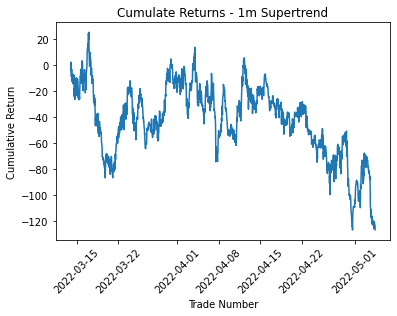

In [138]:
# PLOT THE CUMULATIVE RETURNS 
# plt.figure(figsize=(12,7))
plt.plot(trigs_res1.time,cumulative_rets)
plt.title("Cumulate Returns - 1m Supertrend")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)


plt.show();

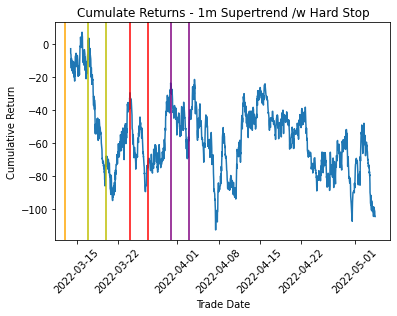

In [139]:
plt.plot(trigs_res1.time, cum_rets_hard)
plt.title("Cumulate Returns - 1m Supertrend /w Hard Stop")
plt.xlabel("Trade Date")
plt.xticks(rotation=45)

plt.axvline(x=pd.to_datetime("2022-03-13 00:00:00"), color="orange")

plt.axvline(x=pd.to_datetime("2022-03-17 00:00:00"), color="y")
plt.axvline(x=pd.to_datetime("2022-03-20 00:00:00"), color="y")

plt.axvline(x=pd.to_datetime("2022-03-24 00:00:00"), color="r")
plt.axvline(x=pd.to_datetime("2022-03-27 00:00:00"), color="r")

plt.axvline(x=pd.to_datetime("2022-03-31 00:00:00"), color="purple")
plt.axvline(x=pd.to_datetime("2022-04-03 00:00:00"), color="purple")
# 2022-03-14 00:09:00
plt.ylabel("Cumulative Return");

#### NARRATIVE
THESE GRAPHS ARE INTERESTING
1. A worse case graph would show a slow burn death to REKt status. 
2. Our graphs show distinct periods of loss followed by distinct gains. 
3. The distinct periods of loss seem to be boundaried by Thursdays at 00:00 and Sundays at 00:00
4. If we had only traded between Sunday 00:00 and Thursday at 00:00 (in this period) our strategy would have achieved a very different result!!
5. Let's see what that result would've been if we'd only trade Monday - Thursday?!?!?!?!

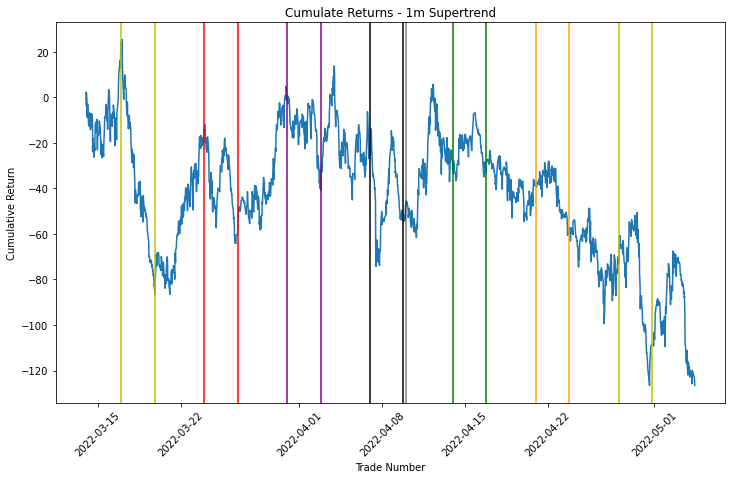

In [170]:
# First let's plot the best boundaries on the original cumulative return graph
# PLOT THE CUMULATIVE RETURNS 
plt.figure(figsize=(12,7))
plt.plot(trigs_res1.time,cumulative_rets)
plt.title("Cumulate Returns - 1m Supertrend")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)

# Plot verticals - optimised to start at 1930 on Saturdays which is the best trade start time in our set
plt.axvline(x=pd.to_datetime("2022-03-17 00:00:00"), color="y")
plt.axvline(x=pd.to_datetime("2022-03-19 19:30:00"), color="y")

plt.axvline(x=pd.to_datetime("2022-03-24 00:00:00"), color="r")
plt.axvline(x=pd.to_datetime("2022-03-26 19:30:00"), color="r")

plt.axvline(x=pd.to_datetime("2022-03-31 00:00:00"), color="purple")
plt.axvline(x=pd.to_datetime("2022-04-02 19:30:00"), color="purple")

plt.axvline(x=pd.to_datetime("2022-04-07 00:00:00"), color="k")
plt.axvline(x=pd.to_datetime("2022-04-09 19:30:00"), color="k")
plt.axvline(x=pd.to_datetime("2022-04-10 00:00:00"), color="k", alpha=0.5)

plt.axvline(x=pd.to_datetime("2022-04-14 00:00:00"), color="green")
plt.axvline(x=pd.to_datetime("2022-04-16 19:30:00"), color="green")

plt.axvline(x=pd.to_datetime("2022-04-21 00:00:00"), color="orange")
plt.axvline(x=pd.to_datetime("2022-04-23 19:30:00"), color="orange")

plt.axvline(x=pd.to_datetime("2022-04-28 00:00:00"), color="y")
plt.axvline(x=pd.to_datetime("2022-04-30 19:30:00"), color="y")


plt.show();

(array([738229., 738236., 738246., 738253., 738260., 738267., 738276.]),
 <a list of 7 Text major ticklabel objects>)

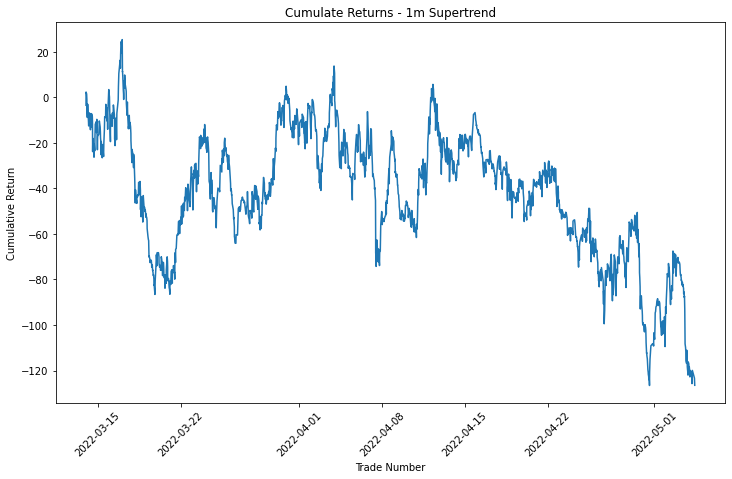

In [208]:
# First let's plot the best boundaries on the original cumulative return graph
# PLOT THE CUMULATIVE RETURNS 
plt.figure(figsize=(12,7))
plt.plot(trigs_res1.time,cumulative_rets)
plt.title("Cumulate Returns - 1m Supertrend")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)

In [141]:
# Get the day of the week that each trade is executed on and build a feature to store it
trigs_res1["day_of_week"] = trigs_res1.apply(lambda row : row.time.day_name(), axis=1)

#### SAVE TRADE SET TO FILE

In [142]:
trigs_res1.to_csv("master_results.csv", index=False)

In [143]:
# Now get Monday to Thursday Trades
trade_days = ["Sunday", "Monday", "Tuesday", "Wednesday"]
trade_days_df = trigs_res1[trigs_res1["day_of_week"].isin(trade_days)]
print(trade_days_df.shape)
trade_days_df

(1191, 22)


,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results,hard_stop,day_of_week
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792000,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.402,-0.115,0,-127.84,-3.564214,-2.710000,Monday
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60,5.810000,-2.710000,Monday
2,84,2022-03-14 01:24:00,38080.27,38094.26,38037.45,38059.44,NaN,38218.679324,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.408,-0.206,0,-28.34,-0.850011,-0.850011,Monday
3,116,2022-03-14 01:56:00,38075.68,38087.78,38069.85,38087.78,37974.284582,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.082,-0.175,0,-97.77,-2.566965,-2.566965,Monday
4,122,2022-03-14 02:02:00,38047.23,38066.65,37990.01,37990.01,NaN,38152.364011,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.003,-0.473,0,-181.47,-4.776782,-2.710000,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,73738,2022-05-04 04:58:00,37981.83,37992.17,37981.21,37992.17,37941.527545,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,2.721,-0.111,1,859.58,5.810000,5.810000,Wednesday
2042,73991,2022-05-04 09:11:00,38870.50,38884.80,38844.64,38851.75,NaN,38972.800555,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.000,-0.336,0,-131.53,-3.385433,-2.710000,Wednesday
2043,74016,2022-05-04 09:36:00,38961.24,38998.38,38961.23,38983.28,38888.346164,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.235,-0.072,0,-78.45,-2.012401,-2.012401,Wednesday
2044,74026,2022-05-04 09:46:00,38954.56,38954.56,38888.00,38904.83,NaN,39037.197336,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.278,-0.150,0,-44.37,-1.140475,-1.140475,Wednesday


In [144]:
trade_days_df.day_of_week.value_counts()

Monday       312
Tuesday      310
Sunday       286
Wednesday    283
Name: day_of_week, dtype: int64

In [145]:
cum_df = trade_days_df.results.cumsum()
cum_stop_df = trade_days_df.hard_stop.cumsum()

In [146]:
trade_days_df.results.sum(), trade_days_df.hard_stop.sum()

(104.53891057306544, 82.37331973447318)

In [147]:
cum_df

0        -3.564214
1         2.245786
2         1.395774
3        -1.171191
4        -5.947973
           ...    
2041    111.077220
2042    107.691787
2043    105.679386
2044    104.538911
2045           NaN
Name: results, Length: 1191, dtype: float64

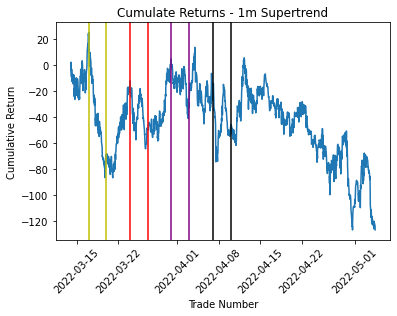

In [148]:
plt.plot(trigs_res1.time,cumulative_rets)
plt.title("Cumulate Returns - 1m Supertrend")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime("2022-03-17"), color="y")
plt.axvline(x=pd.to_datetime("2022-03-20"), color="y")

plt.axvline(x=pd.to_datetime("2022-03-24"), color="r")
plt.axvline(x=pd.to_datetime("2022-03-27"), color="r")

plt.axvline(x=pd.to_datetime("2022-03-31"), color="purple")
plt.axvline(x=pd.to_datetime("2022-04-03"), color="purple")

plt.axvline(x=pd.to_datetime("2022-04-07"), color="k")
plt.axvline(x=pd.to_datetime("2022-04-10"), color="k")


plt.show();


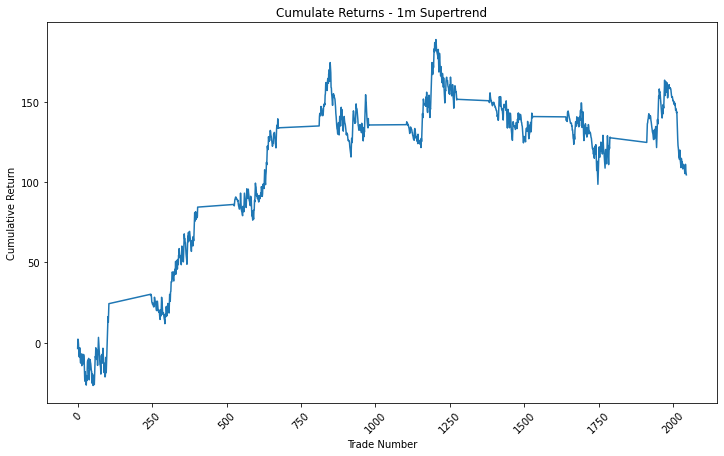

In [149]:
plt.figure(figsize=(12,7))
plt.plot(cum_df)
plt.title("Cumulate Returns - 1m Supertrend")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)

plt.show();

(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]),
 <a list of 11 Text major ticklabel objects>)

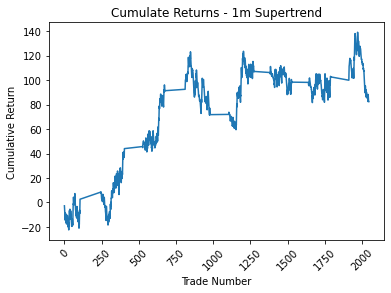

In [150]:
plt.plot(cum_stop_df)
plt.title("Cumulate Returns - 1m Supertrend")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)

In [151]:
adjusted_trades = trigs_res1[(((trigs_res1.time.dt.hour>19)&(trigs_res1.time.dt.minute>29)) & 
            (trigs_res1.day_of_week=="Saturday")) | trigs_res1.day_of_week.isin(trade_days)]
adjusted_trades.head()

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results,hard_stop,day_of_week
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792000,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.402,-0.115,0,-127.84,-3.564214,-2.710000,Monday
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60,5.810000,-2.710000,Monday
2,84,2022-03-14 01:24:00,38080.27,38094.26,38037.45,38059.44,NaN,38218.679324,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.408,-0.206,0,-28.34,-0.850011,-0.850011,Monday
3,116,2022-03-14 01:56:00,38075.68,38087.78,38069.85,38087.78,37974.284582,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.082,-0.175,0,-97.77,-2.566965,-2.566965,Monday
4,122,2022-03-14 02:02:00,38047.23,38066.65,37990.01,37990.01,NaN,38152.364011,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.003,-0.473,0,-181.47,-4.776782,-2.710000,Monday


In [197]:
cum_df_adj = pd.DataFrame(adjusted_trades.results.cumsum())
cum_stop_adj = pd.DataFrame(adjusted_trades.hard_stop.cumsum())

In [198]:
# What do our time_optimised (1930 on Sat - 00 Thurs) strategies return:
cum_df_adj.iloc[-2], cum_stop_adj.iloc[-1]

### NOTE if the last data point is a sellsig/buysig then [-1] will return NAN see below code block

(results    138.489682
 Name: 2044, dtype: float64,
 hard_stop    116.861531
 Name: 2045, dtype: float64)

In [199]:
# cum_df_adj.reset_index(inplace=True, drop=True)

In [200]:
cum_df_adj

,results
0,-3.564214
1,2.245786
2,1.395774
3,-1.171191
4,-5.947973
...,...
2041,145.027991
2042,141.642558
2043,139.630157
2044,138.489682


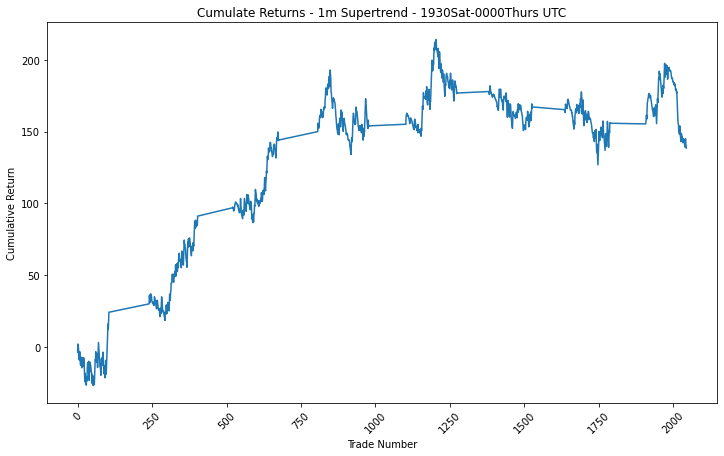

In [207]:
plt.figure(figsize=(12,7))
plt.plot(cum_df_adj)
plt.title("Cumulate Returns - 1m Supertrend - 1930Sat-0000Thurs UTC")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
# plt.xlim(2000,2050)
# plt.ylim(130,220)

plt.show();

In [168]:
adjusted_trades.loc[2010:2018]

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results,hard_stop,day_of_week
2010,72737,2022-05-03 12:17:00,38548.25,38548.25,38502.32,38502.33,NaN,38583.253641,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.253,-0.063,0,-13.40,-0.348031,-0.348031,Tuesday
2011,72757,2022-05-03 12:37:00,38506.42,38518.19,38501.02,38515.73,38431.272930,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.016,-0.224,0,-81.82,-2.124327,-2.124327,Tuesday
2012,72779,2022-05-03 12:59:00,38441.38,38442.45,38420.88,38433.91,NaN,38503.713268,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.565,-0.076,1,10.20,0.590757,0.590757,Tuesday
2013,72814,2022-05-03 13:34:00,38341.38,38469.29,38341.38,38423.71,38222.103382,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.093,-0.507,0,-225.50,-5.868772,-2.710000,Tuesday
2014,72829,2022-05-03 13:49:00,38234.60,38243.09,38147.55,38198.21,NaN,38382.146776,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.036,-0.471,0,-210.32,-5.506017,-2.710000,Tuesday
2015,72840,2022-05-03 14:00:00,38354.86,38409.78,38354.86,38408.53,38208.266012,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.172,-0.289,0,-219.07,-5.703681,-2.710000,Tuesday
2016,72852,2022-05-03 14:12:00,38310.84,38311.53,38173.73,38189.46,NaN,38422.461025,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.083,-0.485,0,-150.35,-3.936950,-2.710000,Tuesday
2017,72907,2022-05-03 15:07:00,38321.94,38361.57,38321.78,38339.81,38210.166776,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.191,-0.194,0,-55.95,-1.459319,-1.459319,Tuesday
2018,72945,2022-05-03 15:45:00,38295.70,38302.57,38279.79,38283.86,NaN,38383.477048,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.074,-0.121,0,-77.21,-2.016777,-2.016777,Tuesday


## STUDY OF LOST WINNERS
Let's remind ourselves that with the current best model we have no lost winners as we have no heard stop.

In [548]:
trigs_res1

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results,hard_stop,day_of_week
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792000,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.402,-0.115,0,-127.84,-3.564214,-2.710000,Monday
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60,5.810000,-2.710000,Monday
2,84,2022-03-14 01:24:00,38080.27,38094.26,38037.45,38059.44,NaN,38218.679324,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.408,-0.206,0,-28.34,-0.850011,-0.850011,Monday
3,116,2022-03-14 01:56:00,38075.68,38087.78,38069.85,38087.78,37974.284582,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.082,-0.175,0,-97.77,-2.566965,-2.566965,Monday
4,122,2022-03-14 02:02:00,38047.23,38066.65,37990.01,37990.01,NaN,38152.364011,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.003,-0.473,0,-181.47,-4.776782,-2.710000,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,52553,2022-04-19 11:53:00,40875.38,40875.38,40787.22,40800.61,NaN,40997.757004,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.332,-0.094,0,-51.54,-1.382116,-1.382116,Tuesday
1477,52571,2022-04-19 12:11:00,40824.81,40852.73,40818.21,40852.15,40703.822752,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.669,-0.046,1,59.38,5.810000,5.810000,Tuesday
1478,52624,2022-04-19 13:04:00,40930.05,40942.28,40906.16,40911.53,NaN,41047.007442,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.150,-0.179,0,-89.10,-2.177870,-2.177870,Tuesday
1479,52644,2022-04-19 13:24:00,40975.38,41004.29,40964.88,41000.63,40878.061882,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.884,-0.318,1,559.77,5.810000,-2.710000,Tuesday


In [549]:
re_entry =  trigs_res1[(trigs_res1.drawdown<(-2.71/10)) & (trigs_res1.drawdown>(-4.2/10))]


In [550]:
print(re_entry.shape)
print(f"Average gain post drawdown: {re_entry.trade_gain.iloc[3:].mean()}%")
re_entry

(137, 22)
Average gain post drawdown: 0.320955223880597%


,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results,hard_stop,day_of_week
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60,5.810000,-2.71,Monday
9,311,2022-03-14 05:11:00,38563.83,38596.04,38540.67,38596.04,38449.576314,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.061,-0.298,0,-110.33,-2.858583,-2.71,Monday
49,1835,2022-03-15 06:35:00,38785.61,38900.00,38773.06,38884.01,38715.015595,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.004,-0.375,0,-187.20,-4.814318,-2.71,Tuesday
51,1927,2022-03-15 08:07:00,38394.62,38467.24,38389.61,38467.24,38271.239606,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.062,-0.346,0,-125.98,-3.274995,-2.71,Tuesday
62,2474,2022-03-15 17:14:00,39149.97,39156.06,39101.74,39116.81,NaN,39267.724909,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.075,-0.290,0,-135.94,-3.475232,-2.71,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,46976,2022-04-15 14:56:00,40487.25,40493.03,40404.41,40418.52,NaN,40733.226645,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.459,-0.390,1,42.58,0.994942,-2.71,Friday
1422,50435,2022-04-18 00:35:00,39727.32,39732.34,39653.11,39656.95,NaN,39794.796026,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.020,-0.294,0,-115.37,-2.909200,-2.71,Monday
1442,51219,2022-04-18 13:39:00,39508.16,39513.55,39368.39,39368.39,NaN,39669.805167,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.290,-0.351,0,-180.31,-4.580070,-2.71,Monday
1456,51752,2022-04-18 22:32:00,40793.37,40794.45,40733.50,40733.50,NaN,40870.246845,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.048,-0.341,0,-175.90,-4.318313,-2.71,Monday


In [551]:
re_ent_buys = re_entry[re_entry.trigger=="buysig"]
re_ent_sells = re_entry[re_entry.trigger=="sellsig"]

In [152]:
re_ent_buys

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results,hard_stop,day_of_week
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,1.343,-0.310,1,219.60,5.810000,-2.71,Monday
9,311,2022-03-14 05:11:00,38563.83,38596.04,38540.67,38596.04,38449.576314,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.061,-0.298,0,-110.33,-2.858583,-2.71,Monday
49,1835,2022-03-15 06:35:00,38785.61,38900.00,38773.06,38884.01,38715.015595,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.004,-0.375,0,-187.20,-4.814318,-2.71,Tuesday
51,1927,2022-03-15 08:07:00,38394.62,38467.24,38389.61,38467.24,38271.239606,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.062,-0.346,0,-125.98,-3.274995,-2.71,Tuesday
67,2641,2022-03-15 20:01:00,39792.05,39852.92,39773.65,39837.74,39620.389247,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.095,-0.394,0,-183.74,-4.612209,-2.71,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,42938,2022-04-12 19:38:00,39572.14,39633.29,39556.65,39622.96,39421.604960,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.012,-0.322,0,-188.15,-4.748509,-2.71,Tuesday
1253,43927,2022-04-13 12:07:00,39834.32,39934.10,39829.42,39879.64,39659.199113,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.059,-0.358,0,-152.37,-3.820747,-2.71,Wednesday
1261,44174,2022-04-13 16:14:00,41266.30,41312.38,41258.54,41303.17,41134.483400,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.133,-0.358,0,-138.78,-3.360033,-2.71,Wednesday
1303,45832,2022-04-14 19:52:00,39756.45,39840.88,39753.87,39825.01,39687.544713,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.076,-0.343,0,-150.70,-3.784054,-2.71,Thursday


In [80]:
trigs.trade_idx[:10]

0      9
1     16
2     84
3    116
4    122
5    155
6    167
7    210
8    271
9    311
Name: trade_idx, dtype: int64

In [182]:
trigs.head(3)

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct
0,9,2022-03-14 00:09:00,37723.24,37725.89,37699.00,37712.00,NaN,37839.792000,sell,sellsig,0.0,0.0,0.0,0.0,0.0
1,16,2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0
2,84,2022-03-14 01:24:00,38080.27,38094.26,38037.45,38059.44,NaN,38218.679324,sell,sellsig,0.0,0.0,0.0,0.0,0.0


In [185]:
trade_num = 1
re_id1 = re_ent_buys.iloc[trade_num].trade_idx
idx1 = trigs[trigs.trade_idx==re_id1].index[0]
idx2 = idx1+1
re_id2 = trigs.loc[idx2].trade_idx
re_id1, re_id2

(311, 335)

In [178]:
trigs.loc[idx2].trade_idx

84

In [175]:
ind_trade = df.loc[re_id1:re_id2]

In [176]:
ind_trade.iloc[:20]

,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct


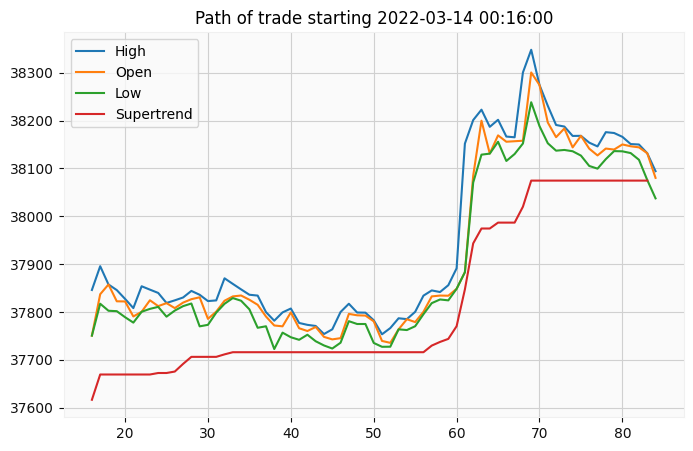

In [168]:
plt.figure(figsize=(8,5))
ind_trade["high"].loc[1:].plot(label="High")
ind_trade["open"].loc[1:].plot(label="Open")
ind_trade["low"].loc[1:].plot(label="Low")
ind_trade["uptrend"].loc[1:].plot(label="Supertrend")
plt.title(f"Path of trade starting {ind_trade.iloc[0].time}")
plt.legend();


In [169]:
ind_trade_t = ind_trade.set_index('time')

In [170]:
ind_trade_t["re_enter"] = ind_trade_t.iloc[0].close

In [147]:
ind_trade_t

,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,re_enter
time,,,,,,,,,,,,,,
2022-03-14 00:16:00,37750.61,37846.00,37750.61,37839.84,37616.556977,NaN,buy,buysig,0.00,0.00,0.000,0.00,0.000,37839.84
2022-03-14 00:17:00,37837.13,37895.69,37817.26,37852.01,37669.372779,NaN,buy,nosig,12.17,55.85,0.148,-22.58,-0.060,37839.84
2022-03-14 00:18:00,37857.50,37857.50,37802.57,37823.16,37669.372779,NaN,buy,nosig,-16.68,17.66,0.047,-37.27,-0.098,37839.84
2022-03-14 00:19:00,37822.35,37845.78,37801.71,37824.73,37669.372779,NaN,buy,nosig,-15.11,5.94,0.016,-38.13,-0.101,37839.84
2022-03-14 00:20:00,37822.03,37827.37,37789.14,37796.86,37669.372779,NaN,buy,nosig,-42.98,-12.47,-0.033,-50.70,-0.134,37839.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-14 01:20:00,38150.13,38166.00,38135.75,38149.60,38074.553829,NaN,buy,nosig,309.76,326.16,0.862,295.91,0.782,37839.84
2022-03-14 01:21:00,38146.31,38150.90,38132.07,38144.08,38074.553829,NaN,buy,nosig,304.24,311.06,0.822,292.23,0.772,37839.84
2022-03-14 01:22:00,38144.07,38150.00,38118.05,38131.74,38074.553829,NaN,buy,nosig,291.90,310.16,0.820,278.21,0.735,37839.84


In [303]:
def renter_plots(num):
    trade_num = num
    re_id1 = re_ent_buys.iloc[trade_num].trade_idx
    idx1 = trigs[trigs.trade_idx==re_id1].index[0]
    idx2 = idx1+1
    re_id2 = trigs.loc[idx2].trade_idx
    result = round(re_ent_buys.iloc[trade_num].results,3)

    ind_trade = df.loc[re_id1:re_id2]
    ind_trade_t = ind_trade.set_index('time')
    ind_trade_t["re_enter"] = ind_trade_t.iloc[0].close
    open_price = round(ind_trade_t['re_enter'][0],3)

    candle_cols = ["open", "high", "low", "close"]
    open_val = ind_trade_t.iloc[0].close
    upper_band = open_val*0.99729
    lower_band = open_val*0.9959

    re_entry_l = open_val*0.999
    re_entry_u = open_val*1.001
    timestp = ind_trade_t.index[0]
    apdict = mpf.make_addplot(ind_trade_t['uptrend'])
    # apdict1 = mpf.make_addplot()
    apdict1 = mpf.make_addplot(ind_trade_t['re_enter'])
    mpf.plot(ind_trade_t[candle_cols], type="candle", addplot=[apdict, apdict1], style="yahoo", 
             figratio=(12,7), fill_between=dict(y1=lower_band, y2=upper_band, alpha=0.5, color="orange"), 
             title=f"Trade start: {timestp}, Result: {result}, Open: {open_price}, TP: {round(open_price*1.006,2)}"
            )


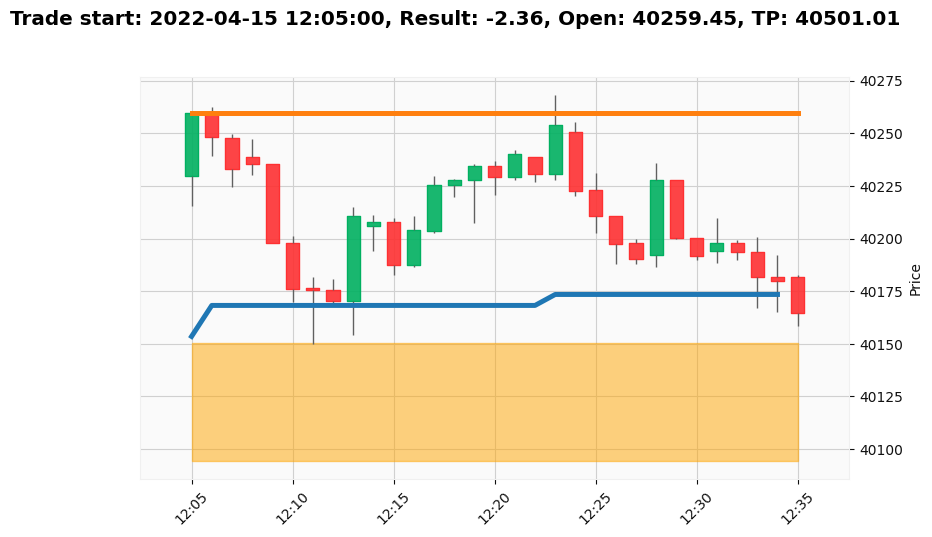

In [467]:
renter_plots(74)

In [313]:
def renter_plots_sells(num):
    trade_num = num
    re_id1 = re_ent_sells.iloc[trade_num].trade_idx
    idx1 = trigs[trigs.trade_idx==re_id1].index[0]
    idx2 = idx1+1
    re_id2 = trigs.loc[idx2].trade_idx
    result = round(re_ent_sells.iloc[trade_num].results,3)

    ind_trade = df.loc[re_id1:re_id2]
    ind_trade_t = ind_trade.set_index('time')
    ind_trade_t["re_enter"] = ind_trade_t.iloc[0].close
    open_price = round(ind_trade_t['re_enter'][0],3)

    candle_cols = ["open", "high", "low", "close"]
    open_val = ind_trade_t.iloc[0].close
    upper_band = open_val*1.004
    lower_band = open_val*1.00271

#     re_entry_l = open_val*0.999
#     re_entry_u = open_val*1.001
    timestp = ind_trade_t.index[0]
    apdict = mpf.make_addplot(ind_trade_t['downtrend'])
    # apdict1 = mpf.make_addplot()
    apdict1 = mpf.make_addplot(ind_trade_t['re_enter'])
    mpf.plot(ind_trade_t[candle_cols], type="candle", addplot=[apdict, apdict1], style="yahoo", 
             figratio=(12,7), fill_between=dict(y1=lower_band, y2=upper_band, alpha=0.5, color="orange"), 
             title=f"Trade start: {timestp}, Result: {result}, Open: {open_price}, TP: {round(open_price*0.994,2)}"
            )


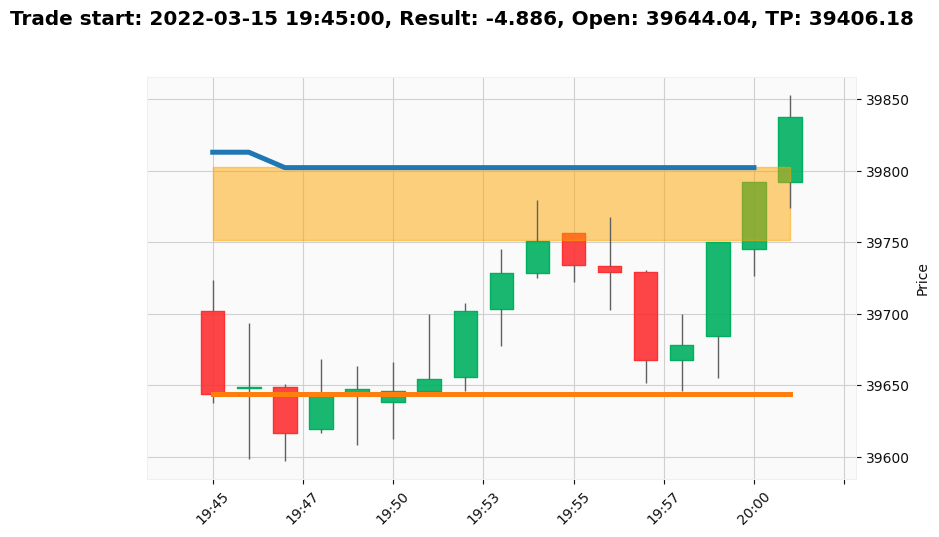

In [380]:
renter_plots_sells(1)

In [366]:
print(re_ent_sells.shape)
re_ent_sells

(58, 22)


,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results,hard_stop,day_of_week
62,2474,2022-03-15 17:14:00,39149.97,39156.06,39101.74,39116.81,NaN,39267.724909,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.075,-0.290,0,-135.94,-3.475232,-2.71,Tuesday
66,2625,2022-03-15 19:45:00,39702.18,39723.77,39637.92,39644.04,NaN,39812.909519,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.118,-0.373,0,-193.70,-4.885980,-2.71,Tuesday
72,2874,2022-03-15 23:54:00,39315.17,39318.70,39283.90,39291.56,NaN,39397.981551,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.188,-0.401,0,-111.97,-2.849721,-2.71,Tuesday
74,2902,2022-03-16 00:22:00,39299.84,39305.30,39227.61,39240.31,NaN,39391.542454,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.160,-0.279,0,-115.13,-2.933973,-2.71,Wednesday
80,3036,2022-03-16 02:36:00,41007.15,41022.03,40787.65,40902.13,NaN,41374.398531,sell,sellsig,0.0,0.0,0.0,0.0,0.0,5.017,-0.326,1,1744.96,5.810000,-2.71,Wednesday
86,3459,2022-03-16 09:39:00,40376.79,40387.61,40265.29,40354.97,NaN,40522.735910,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.119,-0.283,0,-173.50,-4.299347,-2.71,Wednesday
130,4915,2022-03-17 09:55:00,40805.58,40808.96,40716.01,40724.53,NaN,40854.730984,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.500,-0.299,0,-63.30,-1.680831,-2.71,Thursday
136,5129,2022-03-17 13:29:00,40971.67,40971.67,40935.81,40957.90,NaN,41058.361983,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.291,-0.340,0,-98.30,-2.400025,-2.71,Thursday
146,5472,2022-03-17 19:12:00,40813.70,40818.96,40772.23,40774.84,NaN,40908.514257,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.043,-0.330,0,-131.57,-3.226745,-2.71,Thursday
182,6625,2022-03-18 14:25:00,40636.29,40639.80,40601.25,40616.66,NaN,40764.609431,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.032,-0.381,0,-159.64,-3.930407,-2.71,Friday


In [545]:
re_ent_sells.shape

(58, 22)

In [547]:
re_ent_buys.shape

(75, 22)

In [552]:
re_ent_sells.shape, re_ent_buys.shape

((61, 22), (76, 22))

## SANDPIT

#### A SPOT CHECK OF RESULTS AGAINST RESULTS PLOTS
**SPOT CHECK #1**
At the end of the first trade period there is a parabolic winning streak which looks rather suspicious when compared with the overall win rate. Let's have a look at this now.

In [568]:
# Here's the query set for the time in question where we have a large win streak
review_win = adjusted_trades.loc[96:200]
review_win

,trade_idx,time,open,high,low,close,uptrend,downtrend,signal,trigger,close_pl,max_pl,max_pct,max_dd,max_dd_pct,trade_gain,drawdown,close_prof,close_change,results,hard_stop,day_of_week
96,3724,2022-03-16 14:04:00,40578.05,40598.94,40398.67,40450.00,NaN,40827.008026,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.107,-0.763,0,-387.66,-9.583684,-2.71,Wednesday
97,3735,2022-03-16 14:15:00,40704.60,40860.53,40698.33,40837.66,40449.961862,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.941,-0.361,0,-198.42,5.810000,-2.71,Wednesday
98,3762,2022-03-16 14:42:00,40780.79,40794.34,40503.85,40639.24,NaN,41009.243819,sell,sellsig,0.0,0.0,0.0,0.0,0.0,1.388,-0.659,1,298.74,5.810000,-2.71,Wednesday
99,3924,2022-03-16 17:24:00,40285.38,40344.82,40274.62,40340.50,40137.818302,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.875,-0.155,1,10.92,5.810000,5.81,Wednesday
100,3952,2022-03-16 17:52:00,40373.79,40440.26,40328.10,40351.42,NaN,40592.569962,sell,sellsig,0.0,0.0,0.0,0.0,0.0,2.526,-0.477,1,451.41,5.810000,-2.71,Wednesday
101,3999,2022-03-16 18:39:00,39873.01,39934.61,39776.32,39900.01,39391.699151,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,4.007,-0.247,1,1328.80,5.810000,5.81,Wednesday
102,4155,2022-03-16 21:15:00,41277.03,41279.00,41228.81,41228.81,NaN,41404.622420,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.762,-0.052,1,24.27,5.810000,5.81,Wednesday
103,4191,2022-03-16 21:51:00,41178.40,41206.84,41172.54,41204.54,41005.477424,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.078,-0.297,0,-144.25,-3.500828,-2.71,Wednesday
104,4217,2022-03-16 22:17:00,41110.17,41110.31,41057.67,41060.29,NaN,41213.088072,sell,sellsig,0.0,0.0,0.0,0.0,0.0,0.674,-0.129,1,101.03,5.810000,5.81,Wednesday
105,4263,2022-03-16 23:03:00,40839.47,40965.47,40839.47,40959.26,40834.242220,NaN,buy,buysig,0.0,0.0,0.0,0.0,0.0,0.633,-0.114,1,67.39,5.810000,5.81,Wednesday


#### NARRATIVE
Yes this win streak checks out. The strategy returned 8 wins out of 9 trades in this particular period. This puts most concerns to bed regarding suspicious looking win streaks. 

We can see the candlestick chart for each of the trades below....

In [581]:
#### THIS FUNCTION ALSO GENERALISED FOR RE-ENTRIES WHEN BOUNCING OFF THE 2.71-4.1% drawdown zone ####

def renter_plots_streaks(num):
    # Pass the argument to a variable
    trade_num = num
    # Get the master index of the first row in the query set
    re_id1 = review_win.iloc[trade_num].trade_idx
    idx1 = trigs[trigs.trade_idx==re_id1].index[0]
    idx2 = idx1+1
    # Get the master index of the last row in the query set
    re_id2 = trigs.loc[idx2].trade_idx
    # Get the trade result
    result = round(review_win.iloc[trade_num].results,3)
    
    # Query the full trade data (all 1minute oHLC data) 
    ind_trade = df.loc[re_id1:re_id2]
    ind_trade_t = ind_trade.set_index('time')
    # Add a reentry price
    ind_trade_t["re_enter"] = ind_trade_t.iloc[0].close
    open_price = round(ind_trade_t['re_enter'][0],3)
    
    # Set the reuired features
    candle_cols = ["open", "high", "low", "close"]
    # Get the trade open price
    open_val = ind_trade_t.iloc[0].close
    
    
    # If we have a sell trade - plot the candlestick chart / indicators and rejection / re-entry levels
    if review_win.iloc[trade_num].trigger=="sellsig":
        upper_band = open_val*1.004
        lower_band = open_val*1.00271

        timestp = ind_trade_t.index[0]
        apdict = mpf.make_addplot(ind_trade_t['downtrend'])

        apdict1 = mpf.make_addplot(ind_trade_t['re_enter'])
        mpf.plot(ind_trade_t[candle_cols], type="candle", addplot=[apdict, apdict1], style="yahoo", 
                 figratio=(12,7), fill_between=dict(y1=lower_band, y2=upper_band, alpha=0.5, color="orange"), 
                 title=f"Trade start: {timestp}, Result: {result}, Open: {open_price}, TP: {round(open_price*0.994,2)}"
                )
    
    # Else we will havea buy trade - plot the candlestick chart / indicators and rejection / re-entry levels
    else:
        upper_band = open_val*0.99729
        lower_band = open_val*0.9959

        re_entry_l = open_val*0.999
        re_entry_u = open_val*1.001
        timestp = ind_trade_t.index[0]
        apdict = mpf.make_addplot(ind_trade_t['uptrend'])
        
        apdict1 = mpf.make_addplot(ind_trade_t['re_enter'])
        mpf.plot(ind_trade_t[candle_cols], type="candle", addplot=[apdict, apdict1], style="yahoo", 
                 figratio=(12,7), fill_between=dict(y1=lower_band, y2=upper_band, alpha=0.5, color="orange"), 
                 title=f"Trade start: {timestp}, Result: {result}, Open: {open_price}, TP: {round(open_price*1.006,2)}"
                )


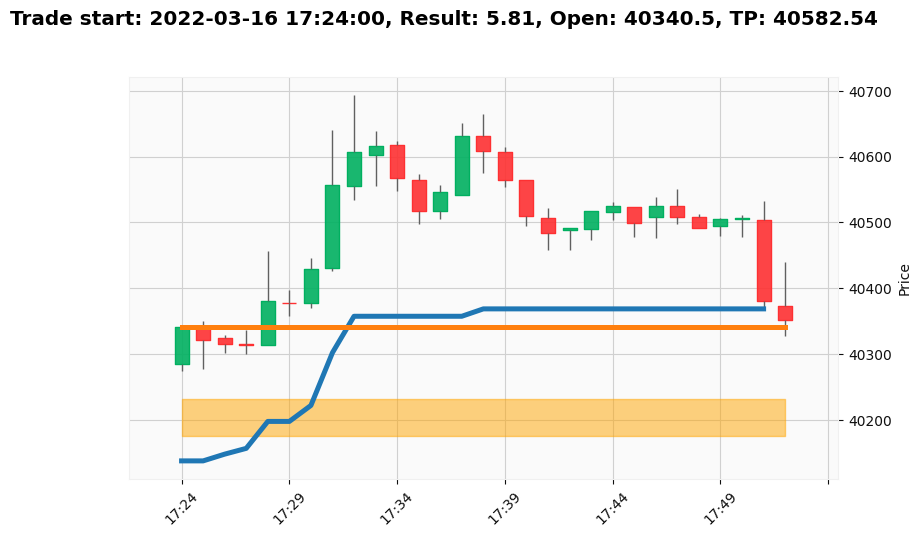

In [586]:
renter_plots_streaks(3)